Customer retention is one of the most used business metrics because the difficulty to acquire a new customer is far greater than retaining an existing customer.

Objectives:
- Determine what's the most important cause of churn
- Create a model that can predict the likelihood of a custmer churning

# Notebook setup

- Import the libraries used for data exploration and visualization
- Disable warnings for a cleaner notebook
- Disabling trunkating when printing dataframe
- Disable scrolling inside output area to have full output all the time

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from scipy import stats
import personal

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.style.use('seaborn')

 # Disable trunkating the middle of long dataframes. I want to see all the columns.
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Explore data

In this step I get a feel for the data:
- What kind of variables the dataframe has
- Make sure all data is  represented correctly

In [5]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

def convert(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

# Convert column names to snake case, since some columns start with uppercase, others with lowercase letters. This will help with autocompletion.
data.columns = [convert(x) for x in data.columns]

data.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data types

In [6]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customer_id          7043 non-null object
gender               7043 non-null object
senior_citizen       7043 non-null int64
partner              7043 non-null object
dependents           7043 non-null object
tenure               7043 non-null int64
phone_service        7043 non-null object
multiple_lines       7043 non-null object
internet_service     7043 non-null object
online_security      7043 non-null object
online_backup        7043 non-null object
device_protection    7043 non-null object
tech_support         7043 non-null object
streaming_tv         7043 non-null object
streaming_movies     7043 non-null object
contract             7043 non-null object
paperless_billing    7043 non-null object
payment_method       7043 non-null object
monthly_charges      7043 non-null float64
total_charges        7043 non-null object
churn                7043 non-null object
dtypes: floa

total_charges is being represented as `object` instead of `float`. There's something fishy going on.

There are 11 observations without total_charges. But that's because their tenure is 0 months, they haven't been charged yet. I can just set the total charges to 0.

In [7]:
total_charges = pd.to_numeric(data.total_charges, errors='coerce')
empty = total_charges[total_charges.isna()]
total_charges[empty.index.values] = 0
data.total_charges = total_charges

In [8]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customer_id          7043 non-null object
gender               7043 non-null object
senior_citizen       7043 non-null int64
partner              7043 non-null object
dependents           7043 non-null object
tenure               7043 non-null int64
phone_service        7043 non-null object
multiple_lines       7043 non-null object
internet_service     7043 non-null object
online_security      7043 non-null object
online_backup        7043 non-null object
device_protection    7043 non-null object
tech_support         7043 non-null object
streaming_tv         7043 non-null object
streaming_movies     7043 non-null object
contract             7043 non-null object
paperless_billing    7043 non-null object
payment_method       7043 non-null object
monthly_charges      7043 non-null float64
total_charges        7043 non-null float64
churn                7043 non-null object
dtypes: flo

Most of the columns are Yes/No/Other. senior_citizen is 0/1. Change that to Yes/No while I'm exploring the data.

In [9]:
data.senior_citizen = list(map(lambda x: 'Yes' if x == 1 else 'No', data.senior_citizen))
data.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Unique values

In [10]:
data.nunique()

customer_id          7043
gender               2   
senior_citizen       2   
partner              2   
dependents           2   
tenure               73  
phone_service        2   
multiple_lines       3   
internet_service     3   
online_security      3   
online_backup        3   
device_protection    3   
tech_support         3   
streaming_tv         3   
streaming_movies     3   
contract             3   
paperless_billing    2   
payment_method       4   
monthly_charges      1585
total_charges        6531
churn                2   
dtype: int64

Often some datasets have variables that have a single unique value, which can be dropped as they provide no value. It is not the case for this dataframe.

## Causes of churn

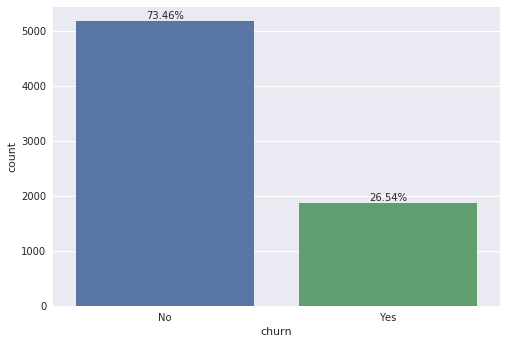

In [11]:
ax = sns.countplot(data=data, x='churn');
personal.show_percent(ax, 2)

Roughly 1/4th of the customers have churn = Yes. Our dataset is not unbalanced.

### Categorical variables

'No phone service' and 'No internet service' provide no extra value, replace them with 'No'.

In [12]:
data.replace({'No phone service': 'No', 'No internet service': 'No'}, inplace=True)

In [13]:
categorical = [column for column in data.columns if data[column].nunique() < 5]
# Remove churn
categorical = categorical[:-1]
categorical

['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'contract',
 'paperless_billing',
 'payment_method']

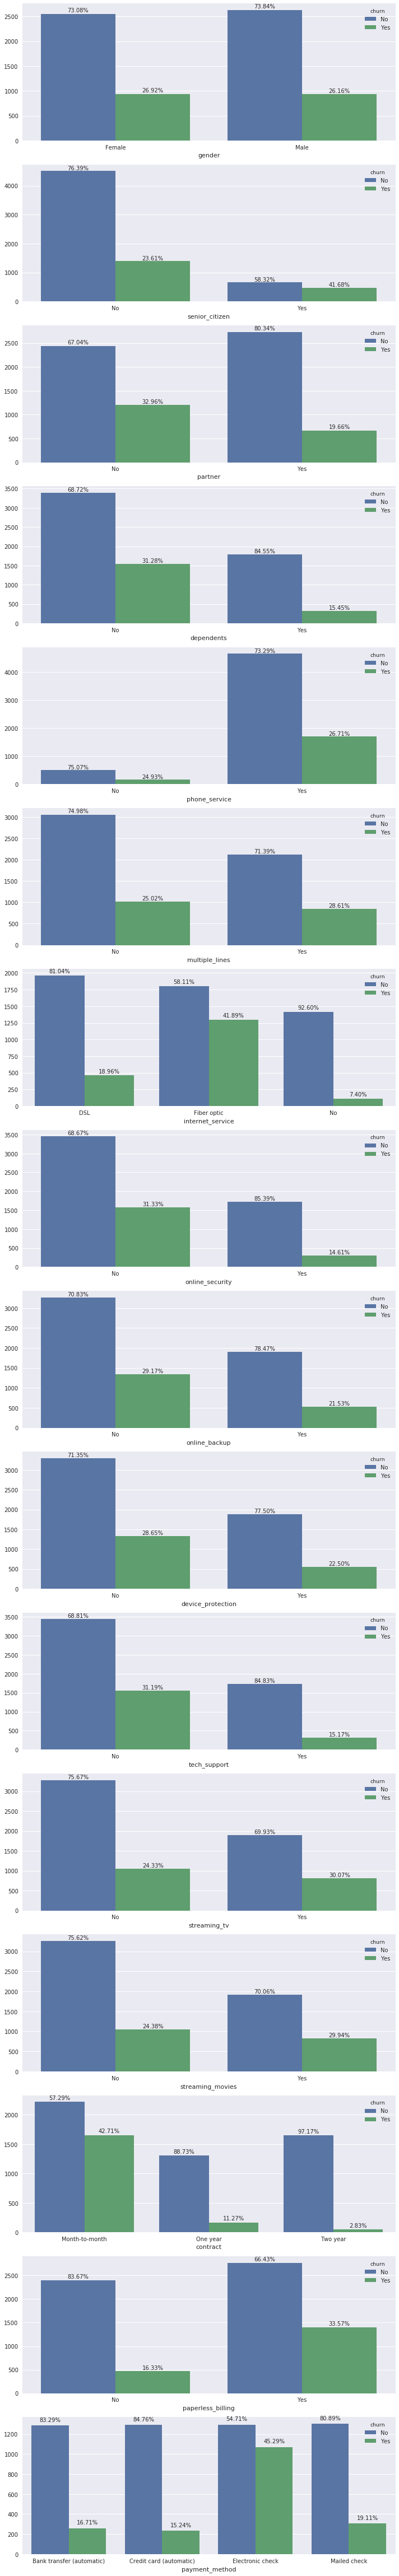

In [14]:
plot_count = len(categorical)
fig, _ = plt.subplots(plot_count, 1, figsize=(10, 4 * plot_count))

for index, category in enumerate(categorical):
    plt.subplot(plot_count, 1, index + 1)
    
    order = sorted(data[category].unique())
    ax = sns.countplot(category, data=data, hue="churn", order=order)
    ax.set_ylabel('')
    
    personal.show_percent(ax, 2)
    
fig.tight_layout()

Observations:
- No noticable different between genders
- Senior citizens are nearly twice as likely to churn
- Having a partner or dependent sign up for our service reduces churn. Later I will investigate having both partner and dependent and having neither
- Phone service does not seem to affect churn rate
- Using any additional service reduces churn
- Longer term contracts reduce churn
- Paperless billing seems to increase churn
- Paying by electronic checks seems to significantly increase churn. Investigate correlation vs causation

In [15]:
def partner_and_dependant(row):
    if row['partner'] == 'No' and row['dependents'] == 'No':
        return 'Neither'
    if row['partner'] == 'No':
        return 'Just dependents'
    if row['dependents'] == 'No':
        return 'Just partner'
    return 'Both'

data['partner_and_dependant'] = data.apply(lambda row: partner_and_dependant(row), axis=1)

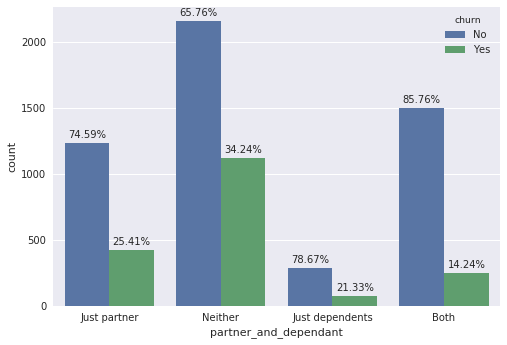

In [16]:
ax = sns.countplot('partner_and_dependant', data=data, hue='churn')
personal.show_percent(ax, 2)

Just as expected, churn rate is lower if both dependents and partner is signed up.
However, churn rate is lower with only dependents against only partner. I would expect partner to matter more. Maybe the sample size is small?

### Numeric variables

#### Tenure

In [17]:
data.tenure.describe()

count    7043.000000
mean     32.371149  
std      24.559481  
min      0.000000   
25%      9.000000   
50%      29.000000  
75%      55.000000  
max      72.000000  
Name: tenure, dtype: float64

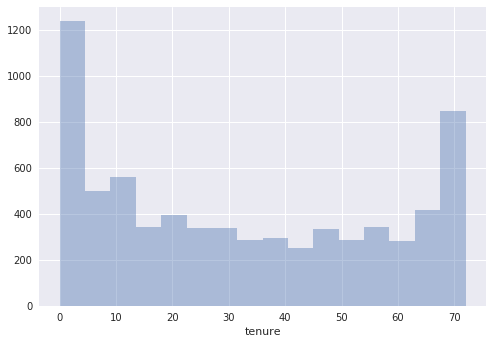

In [18]:
sns.distplot(data.tenure, kde=False);

There are many new clients and many very old clients. Not exactly the distribution I was expecting, but most likely the oldest clients were here before data collection was started.

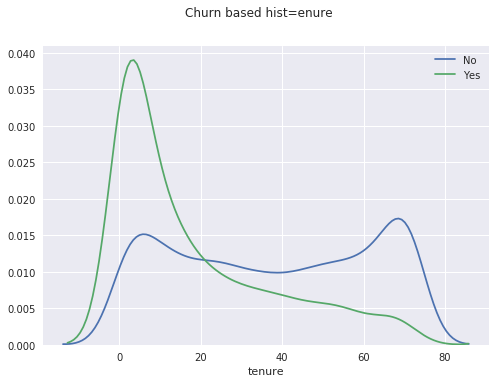

In [19]:
_, ax = plt.subplots(1, 1)
plt.suptitle('Churn based hist=enure')
sns.distplot(data.tenure[data.churn == 'No'], hist=False, label='No')
sns.distplot(data.tenure[data.churn == 'Yes'], hist=False, label='Yes');
ax.legend();

There's a very high rate of churn for new customers, then it decreases with tenure.

#### Monthly charges

In [20]:
data.monthly_charges.describe()

count    7043.000000
mean     64.761692  
std      30.090047  
min      18.250000  
25%      35.500000  
50%      70.350000  
75%      89.850000  
max      118.750000 
Name: monthly_charges, dtype: float64

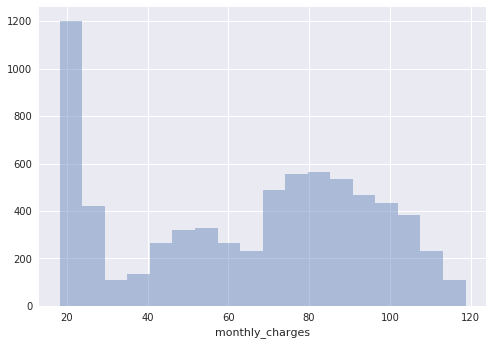

In [21]:
sns.distplot(data.monthly_charges, kde=False);

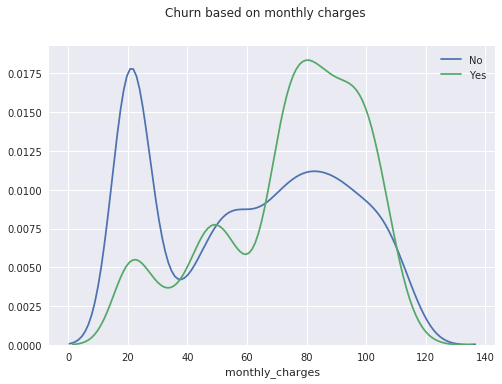

In [22]:
_, ax = plt.subplots(1, 1)
plt.suptitle('Churn based on monthly charges');
sns.distplot(data.monthly_charges[data.churn == 'No'], hist=False, label='No')
sns.distplot(data.monthly_charges[data.churn == 'Yes'], hist=False, label='Yes');
ax.legend();

Very low churn rate if monthly charges are low. Our cheapest service price is lower than competition. However, churn increases substancially if montly charges are high. 

At this point I could compare some of our premium features to competition. However, this is unavailable in this dataset.

In [23]:
more_expensive = data[data.monthly_charges > 40]
me_count = len(more_expensive)
me_percent = me_count / len(data)

print(me_count, ",", me_percent)

5205 , 0.7390316626437597


I have 5205 clients, 74% of total who pay for more than the cheapest option.

#### Total charges

In [24]:
data.total_charges.describe()

count    7043.000000
mean     2279.734304
std      2266.794470
min      0.000000   
25%      398.550000 
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: total_charges, dtype: float64

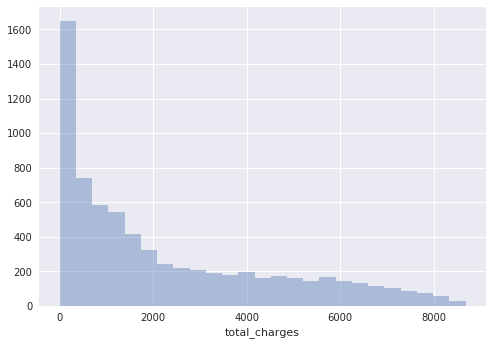

In [25]:
sns.distplot(data.total_charges, kde=False);

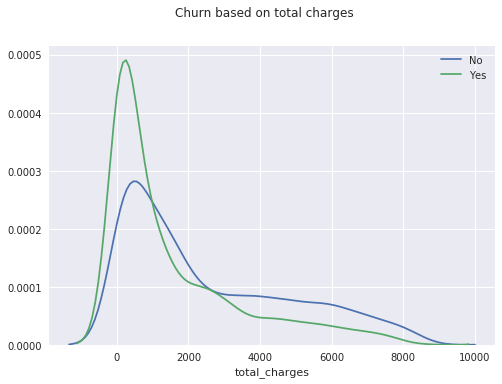

In [26]:
figure, ax = plt.subplots(1, 1);
plt.suptitle('Churn based on total charges')
sns.distplot(data.total_charges[data.churn == 'No'], hist=False, label='No');
sns.distplot(data.total_charges[data.churn == 'Yes'], hist=False, label='Yes');
ax.legend();

Churn seems to decrease with total charges, however this is likely due to tenure.

## Correlation

Convert categorical variables.

In [27]:
data.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,partner_and_dependant
0,7590-VHVEG,Female,No,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Just partner
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,Neither
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Neither
3,7795-CFOCW,Male,No,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Neither
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Neither


In [28]:
corr_data = data.drop('customer_id', axis=1)
corr_data.replace({'Yes': 1, 'No': 0}, inplace=True)
corr_data = pd.get_dummies(corr_data, drop_first=True)

corr_data.head()

,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,gender_Male,internet_service_DSL,internet_service_Fiber optic,contract_One year,contract_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,partner_and_dependant_Just dependents,partner_and_dependant_Just partner,partner_and_dependant_Neither
0,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,0,1,0,0,0,0,1,0,0,1,0
1,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,1,1,0,1,0,0,0,1,0,0,1
2,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,1,1,0,0,0,0,0,1,0,0,1
3,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,1,1,0,1,0,0,0,0,0,0,1
4,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,0,0,1,0,0,0,1,0,0,0,1


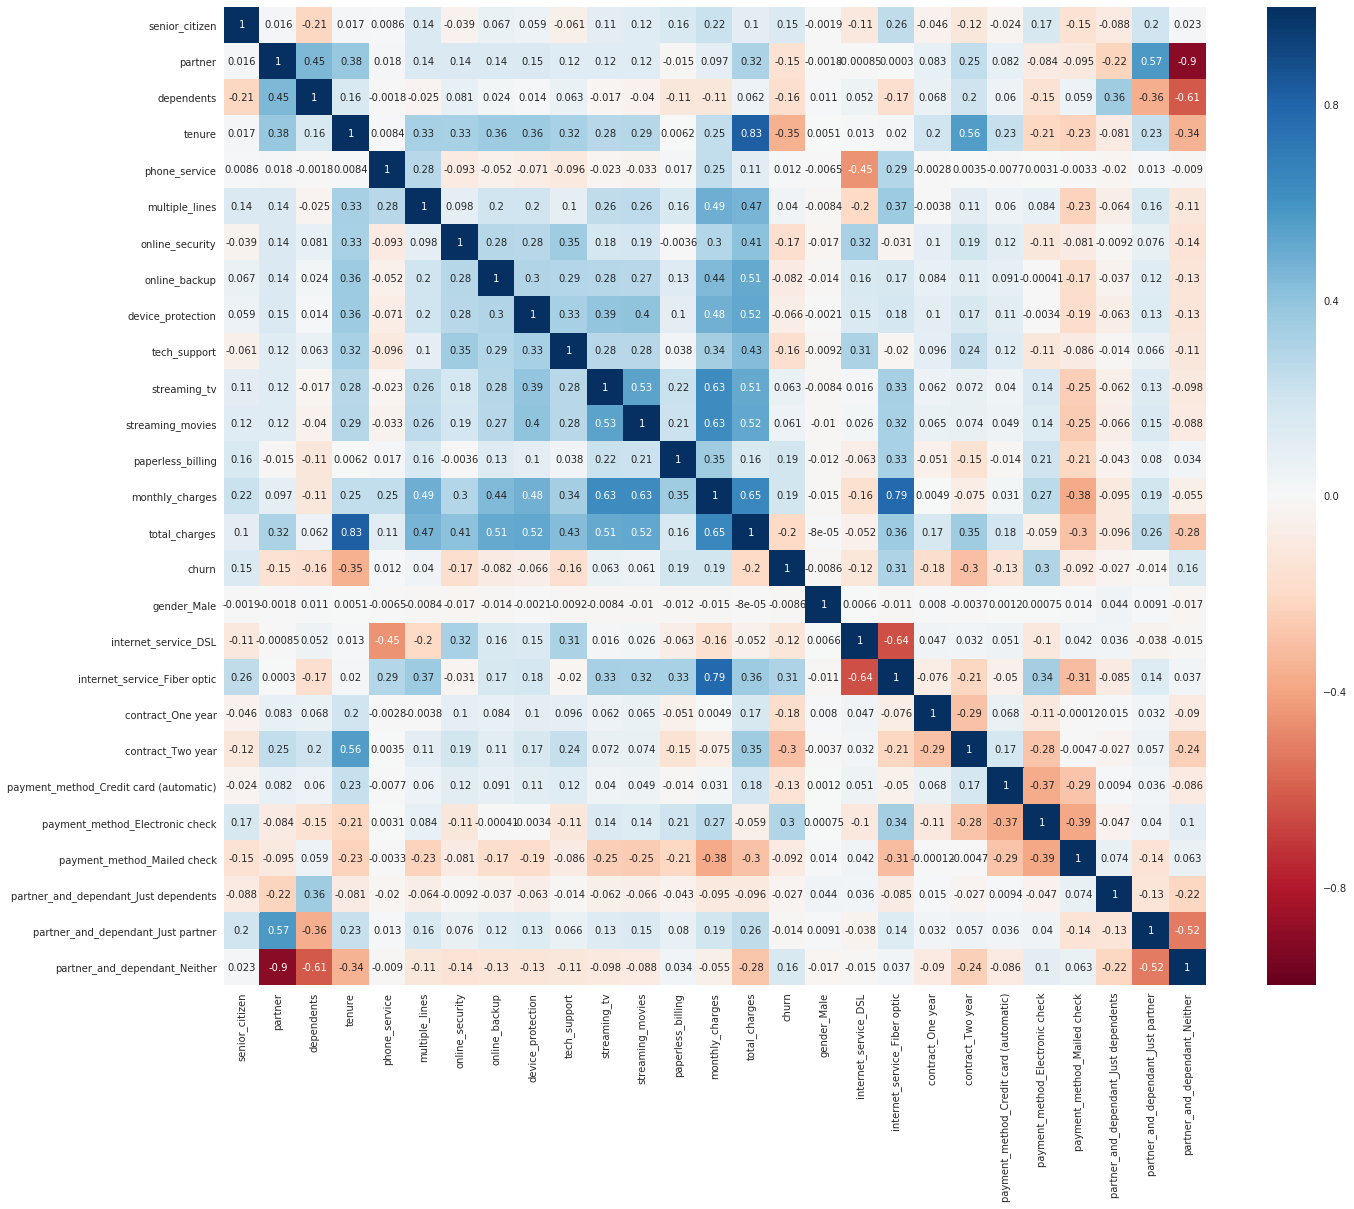

In [29]:
corr = corr_data.corr()

plt.figure(figsize=(22, 18))
sns.heatmap(corr, cmap=plt.cm.RdBu, annot=True, vmin=-1, vmax=1);

Total charges is highly correlated with tenure. Obviously. Consider if one should be excluded from the model.
Monthly charges is highly correlated with internet service. Changing the price of internet service would have a drastic (positive or negative) effect on our costumers.

# Conclusions:
- Customers with low monthly charges are very likely to stay.
- Long time customers are more likely to stay
- Customers are more likely to leave if monthly charges are higher.
- Senior citizens are nearly twice as likely to leave, 42% vs 24%. Are we overcharging them on services they don't use?
- It is very important to have relatives sign up. Churn rate is:
    - 34% with neither partner nor dependents
    - 25% with just partner
    - 21% with just dependents
    - 14% with partner and dependents
- No real difference between genders
- Having internet service, especially fiber optic increases churn. Are we overcharging compared to competition?
- Any additional service on top of internet reduces churn. Let sales people know.
- The longer the contract, the lower the churn:
    - 43% for month-to-month contract
    - 11% for one year contract
    - 3% for two year contract

# Feature engineering

I've already created 'partner_and_dependant' while exploring the data.

## Additional services
Using any extra internet services seems to decrease churn. Capture that into a variable.

In [30]:
data.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,partner_and_dependant
0,7590-VHVEG,Female,No,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Just partner
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,Neither
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Neither
3,7795-CFOCW,Male,No,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Neither
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Neither


In [31]:
additional_services = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
data['count_additional_services'] = (data[additional_services] == 'Yes').sum(axis=1)

## Change in monthly charges
There seems to be a different between tenure \* monthly_charges and total_charges, meaning some clients changed services or price increased along the years.
If tenure \* monthly_charges > total_charges, the client used to pay less than now.

It would be helpful if there was some time series data about when and why clients had their monthly chargers changes, but again, this is unavailable.

In [32]:
data['price_change'] = data.tenure * data.monthly_charges - data.total_charges

# Modelling

In [33]:
baseline = len(data[data.churn == 'No']) / len(data)

The basile the model has to beat is: 0.736.

In [34]:
model_y = data.churn.replace({'Yes': 1, 'No': 0}).astype(int)
model_x = data.drop(['customer_id', 'churn'], axis=1)

In [35]:
model_x.replace({'Yes': 1, 'No': 0}, inplace=True)
model_x = pd.get_dummies(model_x, drop_first=False)

In [36]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import precision_recall_fscore_support

Scale numeric values

In [37]:
model_x.total_charges = preprocessing.scale(model_x.total_charges)
model_x.tenure = preprocessing.scale(model_x.tenure)
model_x.monthly_charges = preprocessing.scale(model_x.monthly_charges)

In [38]:
train_x, test_x, train_y, test_y = train_test_split(model_x, model_y, test_size = 0.2)

In [39]:
kfold = StratifiedKFold(n_splits=10)

random_state = 42
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, train_x, y=train_y, scoring='accuracy',  cv=kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans': cv_means,
                       'CrossValerrors': cv_std,
                       'Algorithm': ['SVC', 'DecisionTree', 'AdaBoost', 'RandomForest', 'ExtraTrees',
                        'GradientBoosting', 'MultipleLayerPerceptron', 'KNeighboors', 'LogisticRegression']
                      })

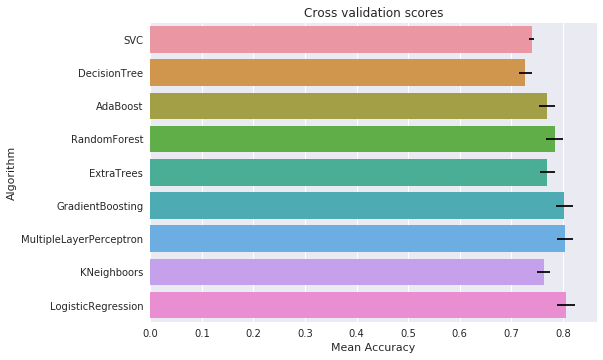

In [40]:
g = sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, orient='h', **{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross validation scores')

Logistic Regression, Gradient Boosting and Mutiple Layer Perceptron perform the best. Random Forest performs somewhat well. Note down for later to investigate with Voting Classifier.

Here I do a Grid Search to find the best parameters. If you have more CPU cores, you can set the number of jobs higher for it to finish faster. If you don't want to run it yourself (it takes around 10 minutes on my CPU), you can find the best parameters a few cells lower.

In [41]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'n_estimators' : [50, 75, 100],
              'learning_rate': [0.2, 0.1, 0.05],
              'max_depth': [3, 4, 8],
              'min_samples_leaf': [100, 150, 200, 250],
              'max_features': [0.5, 0.3, 0.1, 0.05] 
              }

gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose = 1)
gsGBC.fit(train_x, train_y)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   26.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   49.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  5.5min
[Parallel(n_jobs=4)]: Done 4320 out of 4320 | elapsed:  5.8min finished


0.8095491657791978

In [42]:
gsGBC.best_params_

{'learning_rate': 0.2,
 'max_depth': 4,
 'max_features': 0.1,
 'min_samples_leaf': 200,
 'n_estimators': 75}

In [43]:
### MLP Tuning
MLP = MLPClassifier()
param_grid = {
    'alpha': [ 0.3, 1, 2, 3, 10],
    'hidden_layer_sizes': [50, 100, (50, 50), (80, 80)]
}

gsMLP = GridSearchCV(MLP, param_grid=param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsMLP.fit(train_x, train_y)
MLP_best = gsMLP.best_estimator_

gsMLP.best_score_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  1.5min finished


0.808839190628328

In [44]:
gsMLP.best_params_

{'alpha': 0.3, 'hidden_layer_sizes': 50}

In [45]:
LR = LogisticRegression()
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

gsLR = GridSearchCV(LR, param_grid=param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsLR.fit(train_x, train_y)
LR_best = gsLR.best_estimator_

gsLR.best_score_

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    1.1s finished


0.8074192403265885

In [46]:
gsLR.best_params_

{'C': 100}

In [47]:
GBC = GradientBoostingClassifier(learning_rate=0.2, max_depth=3, max_features=0.3, min_samples_leaf=250, n_estimators=75, random_state=42)
GBC.fit(train_x, train_y)

GBC.score(test_x, test_y)

0.7920511000709723

In [48]:
MLP = MLPClassifier(alpha=3, hidden_layer_sizes=100)
MLP.fit(train_x, train_y)

MLP.score(test_x, test_y)

0.7863733144073811

In [49]:
LR = LogisticRegression(C=100, random_state=42)
LR.fit(train_x, train_y)

LR.score(test_x, test_y)

0.7849538679914834

In terms of accuracy, Gradient boosting seems to perform the best. However, I will investigate the confusion matrix

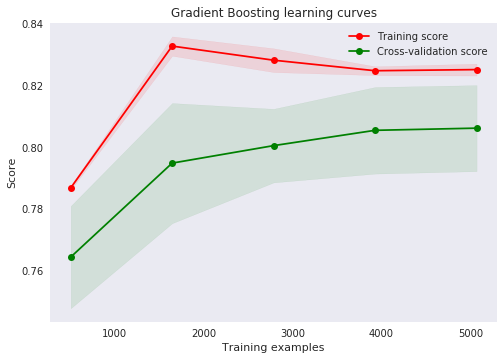

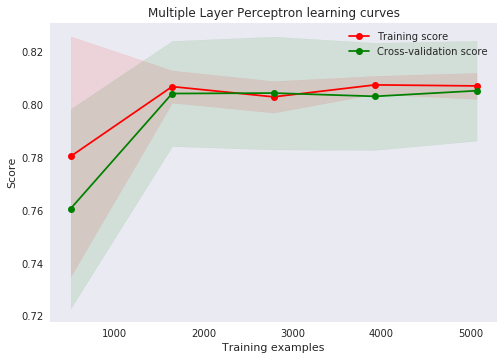

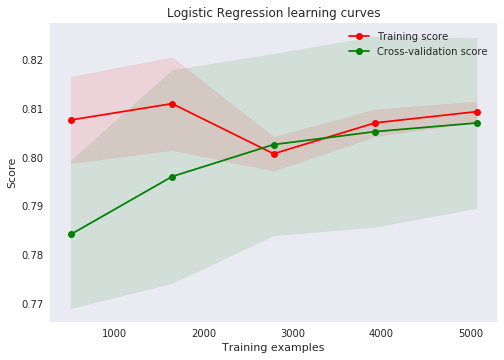

In [50]:
personal.plot_learning_curve(GBC, "Gradient Boosting learning curves", train_x, train_y, cv=kfold)
personal.plot_learning_curve(MLP, "Multiple Layer Perceptron learning curves", train_x, train_y, cv=kfold)
personal.plot_learning_curve(LR, "Logistic Regression learning curves", train_x, train_y, cv=kfold);

The learning curves look fairly normal. Our MLP and Logistic Regression model has high bias, so new data wouldn't help too much. However, it could help for the Gradient Boosting model.

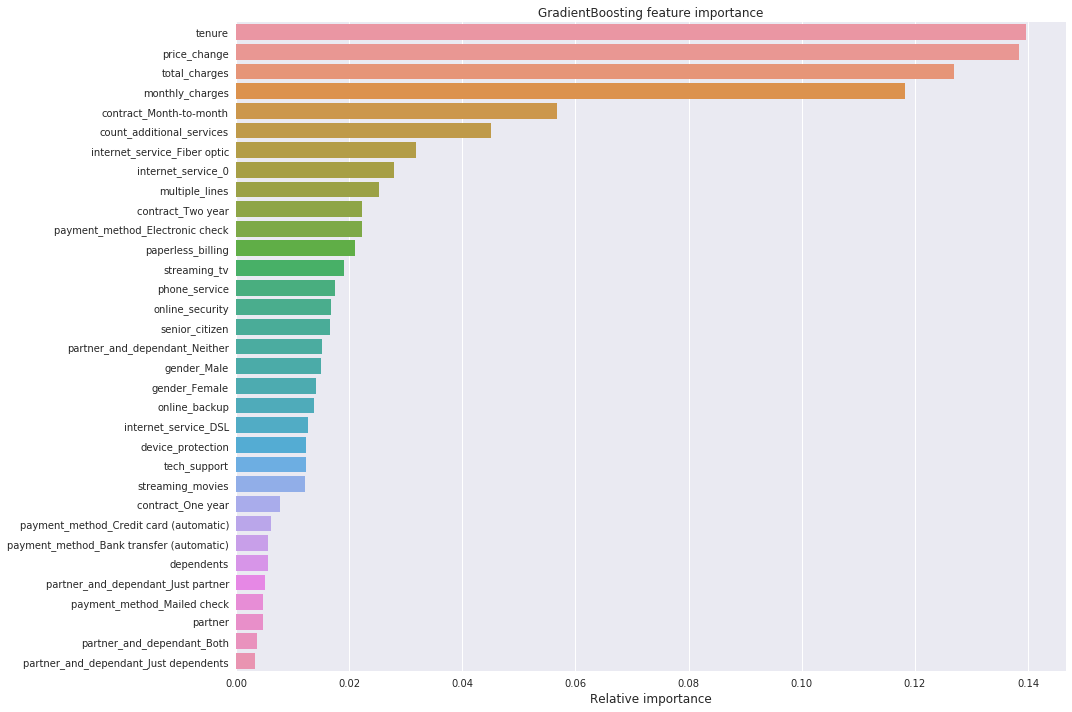

In [51]:
nrows = 1
fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex="all", figsize=(15, 10))

names_classifiers = [("GradientBoosting", GBC_best)]

nclassifier = 0
for row in range(nrows):
    name = names_classifiers[nclassifier][0]
    classifier = names_classifiers[nclassifier][1]
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]
    g = sns.barplot(y=train_x.columns[indices][:40], x=classifier.feature_importances_[indices][:40], orient='h')
    g.set_xlabel("Relative importance", fontsize=12)
    g.set_title(name + " feature importance")
    nclassifier += 1
    
fig.tight_layout()

It seems like the tenure of the client is the most important in reducing churn. Since that cannot be influenced, other important features are:
- How much the client has to pay
- How much the price changed along the years
- After that, the importance of features gradually decreases, but the type of contract seems important
- Finally, the additional internet features are also important

In [52]:
pred_y = GBC.predict(test_x)

precision_recall_fscore_support(test_y, pred_y)

(array([0.82714932, 0.66447368]),
 array([0.8996063 , 0.51399491]),
 array([0.86185761, 0.57962697]),
 array([1016,  393]))

In [53]:
pred_y = LR.predict(test_x)

precision_recall_fscore_support(test_y, pred_y)

(array([0.81915846, 0.65410959]),
 array([0.90059055, 0.48600509]),
 array([0.85794655, 0.55766423]),
 array([1016,  393]))

In [54]:
pred_y = MLP.predict(test_x)

precision_recall_fscore_support(test_y, pred_y)

(array([0.82470481, 0.64935065]),
 array([0.89370079, 0.50890585]),
 array([0.85781767, 0.57061341]),
 array([1016,  393]))

As we can see, all our models perform quite similar to one another.

They are also far better at predicting chorn = no case, which is quite problematic. Depending on how Telco is doing financially and in terms of client growth, it might be better to have more false positives than false negatives.

# Summary

- The most important features when determining client churn were:
    - tenure
    - monthly and total charges
    - changes in price over time
    - various internet services

- I trained different machine learning models to predict client churn and achieved around 80.5% accuracy. This score could still be improved a bit by having more data, however not by too much.